In [3]:
!cv2 version

/bin/bash: cv2: command not found


In [80]:
!pip install split-folders tqdm

In [94]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

## Preprocessing the data

In [61]:
# init the initial learning rate, number of epochs to train for, and batch size
init_lr = 1e-4
epochs = 20
bs = 32
image_size = (192,192)

In [3]:
DIRECTORY = r"data"
CATEGORIES = ["with_mask","without_mask","mask_weared_incorrect"]

In [4]:
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
# get the list of images in our dataset directory, 
# then init the list of data and class images
# X = []
# y = []

# for category in CATEGORIES:
#     path = os.path.join(DIRECTORY, category) # path to mask, no_mask, incorrect
#     # looping over image paths and prepocessing the images
#     for img in os.listdir(path):
#         img_path = os.path.join(path,img)
#         image = load_img(img_path,target_size=(192,192)) # resize all images, target size
#         image = img_to_array(image)
#         image = preprocess_input(image)
#         X.append(image)
#         y.append(category)

In [6]:
# for category in CATEGORIES:
#     path = os.path.join(DIRECTORY, category)
#     for img in os.listdir(path):
#         image = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
#         image = img_to_array(image)
#         image = preprocess_input(image)
#         plt.imshow(img_array, cmap='gray')
#         plt.show(5)
# pass

In [7]:
# one-hot encoding on the labels (1 and 0) binary format
# mlb = LabelBinarizer()
# y = mlb.fit_transform(y)
# labels = to_categorical(labels)

In [8]:
# convert data to arrays b/c hidden layers only accept this format
# X = np.array(X,dtype='float32')
# y = np.array(y)

In [9]:
# split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# splitfolders.ratio('data',output='split_data', seed=1337, ratio=(.8,.1,.1))

In [69]:
# create batch datasets

train_ds = image_dataset_from_directory('data',
                                       validation_split=0.2,
                                       subset='training',
                                       seed=1337,
                                       image_size=image_size,
                                       batch_size=bs)
test_ds = image_dataset_from_directory('data',
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=1337,
                                      image_size=image_size,
                                      batch_size=bs)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.
Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


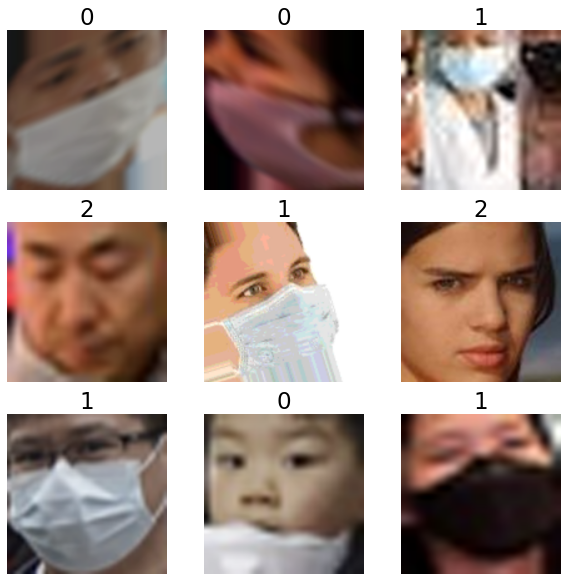

In [70]:
# visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [27]:
# construct the training image generator for data augmentation
# recreating the images

aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [95]:


data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
    
    ]
)

In [111]:
train = aug.flow_from_directory('split_data/train', class_mode='categorical',target_size=(192,192), batch_size=bs)
test = aug.flow_from_directory('split_data/test', class_mode='categorical',target_size=(192,192), batch_size=bs)
val = aug.flow_from_directory('split_data/val',class_mode='categorical',target_size=(192,192), batch_size=bs)

Found 7185 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 897 images belonging to 3 classes.


In [112]:
x_train, y_train = train.next()
x_test,y_test = test.next()
x_val, y_val = val.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (x_test.shape, x_test.min(), x_test.max()))
print(type(x_train))

Batch shape=(32, 192, 192, 3), min=0.000, max=255.000
<class 'numpy.ndarray'>


In [99]:
type(data_augmentation)

tensorflow.python.keras.engine.sequential.Sequential

In [100]:
# load MobileNetV2 network, ensuring the head FC (Fully Connected) laery sets are left off
inputs = Input(shape=(192,192,3))
baseModel = MobileNetV2(input_shape=(192,192,3),weights="imagenet", include_top=False, input_tensor=inputs)

In [34]:
# create the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(6,6))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [35]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# lopp over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable=False

In [46]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=init_lr,decay=init_lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [105]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [106]:
def build_model(num_classes, img_size=192):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(192,192,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(6,6))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [115]:
def keras_generator(aug, path, val):
    datagen = aug
    train = aug.flow_from_directory('split_data/train', class_mode='categorical',target_size=(192,192), batch_size=bs)    
    val = aug.flow_from_directory('split_data/val',class_mode='categorical',target_size=(192,192), batch_size=bs)
    
    num_classes = len(CATEGORIES)
    model = build_model(num_classes)
    
    # train head of the network
    print("[INFO] training head...")
    H = model.fit(
            dataset,
            steps_per_epoch=len(train_ds) // bs,
            validation_data=test_ds,
            validation_steps=len(test_ds) //bs,
            batch_size=bs,
            epochs=epochs,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      verbose=1,
                                                      patience=4,
                                                      restore_best_weights=True)
)

In [116]:
keras_generator(aug, train, val)

Found 7185 images belonging to 3 classes.
Found 897 images belonging to 3 classes.


NotImplementedError: Cannot convert a symbolic Tensor (sequential/random_rotation/rotation_matrix/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [47]:
# train head of the network
print("[INFO] training head...")
H = model.fit(
        train,
        steps_per_epoch=len(x_train[0]) // bs,
        validation_data=val,
        validation_steps=len(x_val[0]) //bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=4,
                                                  restore_best_weights=True)
)

[INFO] training head...


2021-08-27 00:41:27.222101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-27 00:41:27.239665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/20
8/8 [==============================] - 17s 2s/step - loss: 1.4453 - accuracy: 0.3421 - val_loss: 1.2059 - val_accuracy: 0.3633
Epoch 2/20
8/8 [==============================] - 14s 2s/step - loss: 1.4470 - accuracy: 0.3773 - val_loss: 1.1061 - val_accuracy: 0.4258
Epoch 3/20
8/8 [==============================] - 14s 2s/step - loss: 1.4340 - accuracy: 0.3397 - val_loss: 1.0597 - val_accuracy: 0.4648
Epoch 4/20
8/8 [==============================] - 14s 2s/step - loss: 1.3842 - accuracy: 0.3620 - val_loss: 1.0207 - val_accuracy: 0.5430
Epoch 5/20
8/8 [==============================] - 14s 2s/step - loss: 1.1680 - accuracy: 0.4020 - val_loss: 0.9964 - val_accuracy: 0.5898
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 1.1904 - accuracy: 0.3500 - val_loss: 0.9804 - val_accuracy: 0.6016
Epoch 7/20
8/8 [==============================] - 15s 2s/step - loss: 1.1359 - accuracy: 0.4237 - val_loss: 0.9621 - val_accuracy: 0.5977
Epoch 8/20
8/8 [==================

In [49]:
x_test.shape

(32, 256, 256, 3)

In [52]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test[0], batch_size=bs)

[INFO] evaluating network...


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 192, 192, 3), found shape=(32, 256, 3)


In [22]:
# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
ev = model.evaluate(test, batch_size=bs)

29/29 [==============================] - 24s 829ms/step - loss: 1.0074 - accuracy: 0.5089


In [ ]:
print(classification_report(np.argmax(test, axis=1), predIdxs, target_names=['Mask','No Mask','Mask Worn Incorrectly']))